# 타이타익 탑승자 명단을 통한 생존자 분석 및 예측
* 6개 변수, 1개 변수는 생존 결과로 1이면 생존, 0이면 사망
*사망 / 생존 예측하는 이진 분류 문제로 정의

## 1.데이터 준비하기

In [78]:
!pip install koreanize-matplotlib

In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기

In [80]:
raw_data=sns.load_dataset('titanic')
raw_data.info()
raw_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False


## 2.데이터 전처리


### 탐색적 데이터 분석

In [81]:
raw_data.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


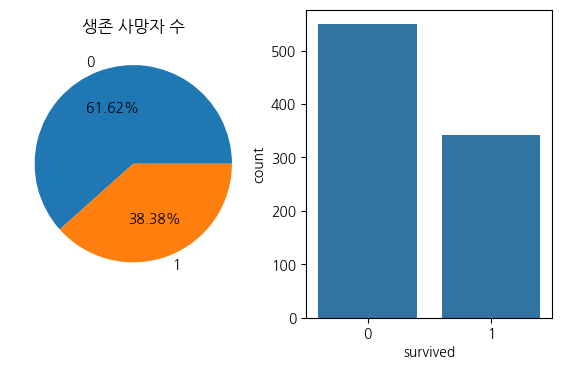

In [82]:
# 생존률 확인 | 6(사망):4(생존) | 데이터 불균형
f , ax =plt.subplots(1,2,figsize=(7,4))  #행 1개 열2개

raw_data['survived'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[0]) #ax축정보
ax[0].set_title('생존 사망자 비율')
ax[0].set_ylabel('')

#오른쪽 바 차트
sns.countplot(data=raw_data, x='survived', ax=ax[1])
ax[0].set_title('생존 사망자 수')

plt.show()

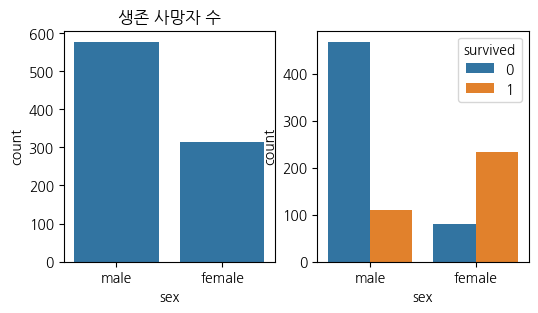

In [83]:
## 성별 생존 수 확인

f , ax =plt.subplots(1,2,figsize=(6,3))  #행 1개 열2개
sns.countplot(data=raw_data, x='sex', ax=ax[0])
ax[0].set_title('탑승객의 성별 수 현황')

sns.countplot(data=raw_data, x='sex',hue='survived', ax=ax[1])
ax[0].set_title('생존 사망자 수')

plt.show()
# 남성이 더 많이 탑승하였고 사망도 더 많이 하였음

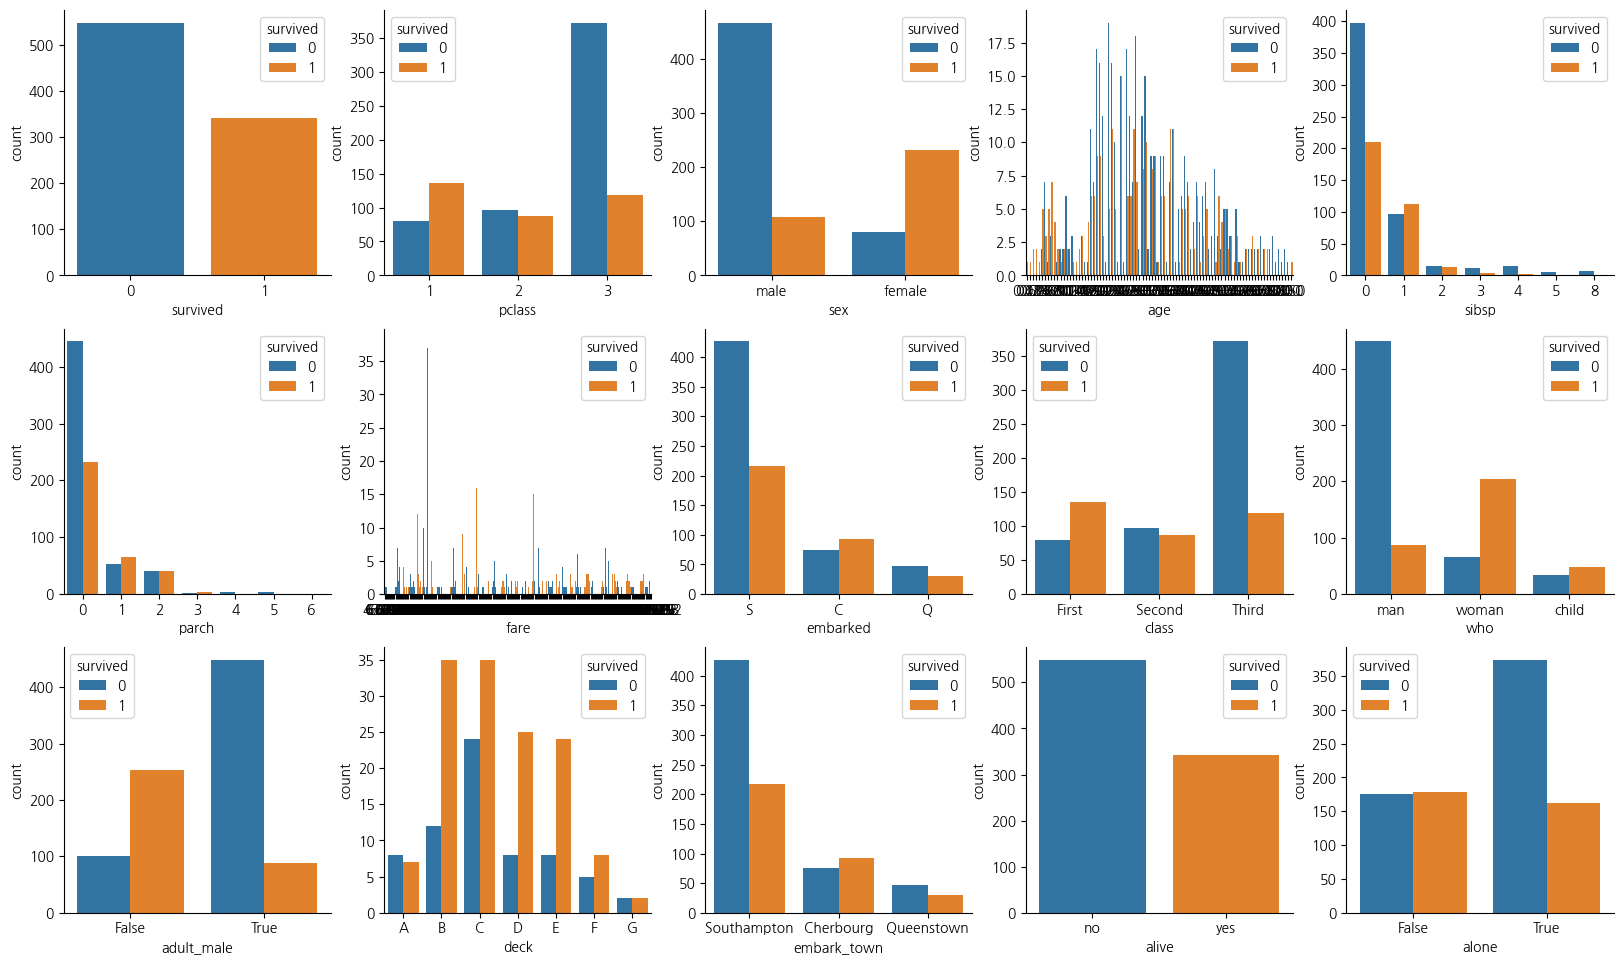

In [84]:
# 모든 컬럼에 대한 생존 여부 확인
attrs=raw_data.columns

plt.figure(figsize=(20,20))

for i, feature in enumerate(attrs):
  plt.subplot(5,5,i+1)
  sns.countplot(data=raw_data,x=feature,hue='survived')

  sns.despine()

### 결측치 처리

In [85]:
# 결측치 확인

raw_data.isna().sum()[raw_data.isna().sum()>0]

,0
age,177
embarked,2
deck,688
embark_town,2


In [86]:
# 1) 결측치 처리 방법 [삭제, 채우기]
# 컬럼 삭제 : deck(객실 데크 위치) , embark_town(탑승 도시, embark 동일)
# 행 삭제 : age

rdf=raw_data.drop(['deck','embark_town'],axis=1)
rdf.isna().sum()[rdf.isna().sum()>0]

,0
age,177
embarked,2


In [87]:
# 2) age 컬럼에서 데이터가 없는 null row삭제 -> 177건
rdf=rdf.dropna(subset=['age'],how='any', axis=0)
rdf.isna().sum()[rdf.isna().sum()>0]

# 총 개수 714건

,0
embarked,2


In [88]:
# 3) embarked 승선 도시 null 2건 -> 승선 도시 중 가장 많이 출현한 도시로 채우기
print(rdf['embarked'].unique())

# 3-1) 가장 많이 승선한 도시 찾아 변수에 담기
most_freq= rdf['embarked'].value_counts().idxmax()

# 3-2) null데이터를 most_freq로 채우기
rdf['embarked'].fillna(most_freq, inplace=True)
rdf.isna().sum()[rdf.isna().sum()>0]

['S' 'C' 'Q' nan]


,0


### 필요한 컬럼 선택

In [89]:
# 4) 학습에 필요한 컬럼만 선택 feature selection
# 생존 여부, 객실 등급, 성별, 나이 , 형제/자녀 수, 부모/자녀수, 지불한 운임,탑승 도시

ndf =rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
ndf.head(2)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C


### 인코딩

In [90]:
# 5) 문장로 된 값을 변환 -> 인코딩
# -> 원핫인코딩(범주형 데이터를 머신러닝 모델이 인식할 수 있는 숫자형으로 변환)
######## 라벨인코딩은 0,1,2... 숫자로 표시되는 머신러닝모델에서 순서로 착각할 수 있음
# ex) 여 ,남 ->int 0,1 -> onehot [1,0] , [0,1]
# ex) ['S' 'C' 'Q']  -> [0,1,2] -> [1,0, 0,] [0,1,0] [0,0,1]

#5-1) 성별, 승선도시 원핫 인코딩 만들기
onehot_sex=pd.get_dummies(ndf['sex']).astype('int')
onehot_embarked=pd.get_dummies(ndf['embarked']).astype('int')
#5-2) ndf 데이터 프레임 연결
ndf =pd.concat([ndf, onehot_sex],axis=1)

ndf =pd.concat([ndf, onehot_embarked],axis=1)

In [91]:
# 6) 기존 칼럼 삭제
ndf.drop(['sex','embarked'],axis=1,inplace=True)
ndf.head(2)

,survived,pclass,age,sibsp,parch,fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0


### 훈련데이터 테스트 데이터 분리

In [92]:
# 특성과 레이블로 분리
x=ndf.iloc[:,1:] #survived 컬럼을 제외한 모든 컬럼(독립변수,feature)
y=ndf.iloc[:,0]  #survived 컬럼만 가져오기(종속변수, label)


In [93]:
# 학습 데이터와 테스트 데이터로 분리 (90:10)
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=777)

In [94]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(642, 10) (72, 10) (642,) (72,)


In [95]:
#훈련 데이터셋에서 검증 데이터셋(학습시 검증용으로 사용) 분리
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=777)

In [96]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(577, 10) (65, 10) (577,) (65,)


# 3.모델 구성하기


In [97]:
from keras.models import Sequential
from keras.layers import Dense

model=Sequential()
model.add(Dense(255,input_shape=(10,),activation='relu'))
model.add(Dense(1,activation='sigmoid'))


# 4.모델 설정

In [98]:
model.compile(loss='binary_crossentropy',
             optimizer='Adam',metrics=['accuracy'])

# 5.모델 학습

In [99]:
history =model.fit(X_train,y_train,
                   validation_data=(X_val,y_val),
                   epochs=40,)

Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6216 - loss: 1.0285 - val_accuracy: 0.6462 - val_loss: 0.8465
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7017 - loss: 0.5775 - val_accuracy: 0.5846 - val_loss: 0.7403
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6540 - loss: 0.6034 - val_accuracy: 0.7077 - val_loss: 0.6828
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7555 - loss: 0.5120 - val_accuracy: 0.7846 - val_loss: 0.5672
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7679 - loss: 0.4897 - val_accuracy: 0.7846 - val_loss: 0.5566
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7605 - loss: 0.5135 - val_accuracy: 0.7385 - val_loss: 0.6935
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7666 - loss: 0.4987 - val_accuracy: 0.8000 - val_loss: 0.5513
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7609 - loss: 0.5182 - val_accuracy: 0.7846 - val_loss

### 학습 결과 확인하기

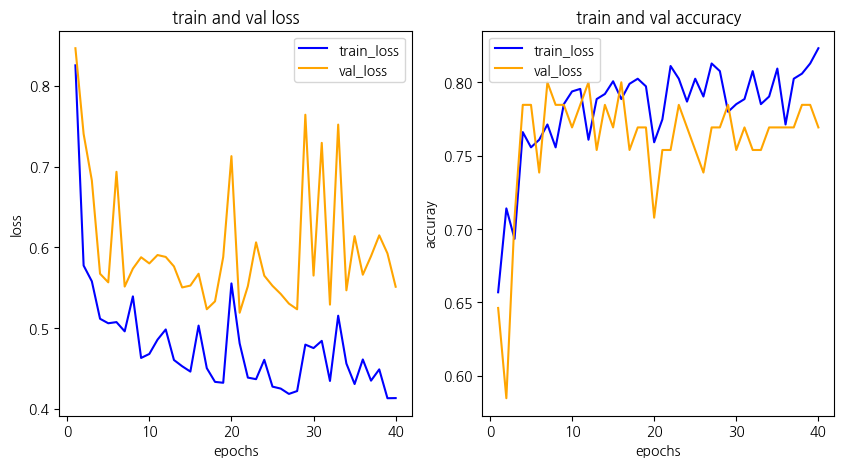

In [100]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 ‘val_’ 수식어가 붙습니다.

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_loss')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_loss')
ax2.set_title('train and val accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuray')
ax2.legend()

plt.show()

# 6.모델 성능 평가

In [104]:
scores = model.evaluate(X_test,y_test)
print('%s :  %.2f%%'%(model.metrics_names[1], scores[1]*100))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7539 - loss: 0.5131
compile_metrics :  75.00%


In [107]:
from sklearn import metrics
y_pred= (model.predict(X_test) > 0.5).astype('int')

print('accuracy: ',metrics.accuracy_score(y_test,y_pred))
print('precision: ',metrics.precision_score(y_test,y_pred))
print('recall: ',metrics.recall_score(y_test,y_pred))
print('f1-score: ',metrics.f1_score(y_test,y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
accuracy:  0.75
precision:  0.6875
recall:  0.7333333333333333
f1-score:  0.7096774193548387


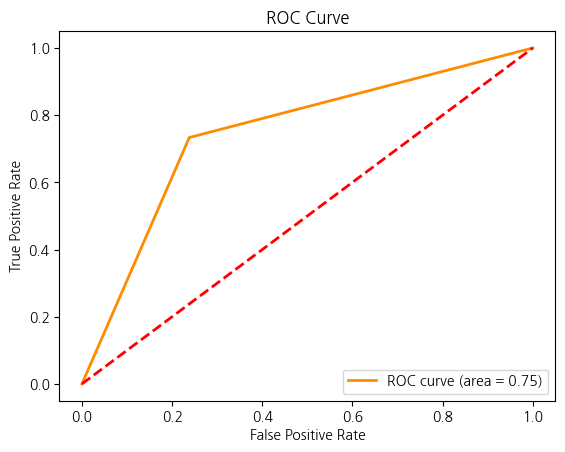

In [108]:
from sklearn.metrics import roc_curve, auc

fpr_A, tpr_A, thr_A = roc_curve(y_test, y_pred)

auc_A = auc(fpr_A, tpr_A)

import matplotlib.pyplot as plt

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


plt.plot(fpr_A, tpr_A, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc_A)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.show()

# 7.모델 예측하기

In [117]:
print(X_test.head(1))

     pclass   age  sibsp  parch  fare  female  male  C  Q  S
441       3  20.0      0      0   9.5       0     1  0  0  1


In [109]:
#              컬럼  등실, 나이, 형제 ,부모자녀,티켓값, 남,성, , C , Q  ,S
dicaprio = np.array([3. , 19  ,  0. ,   0. ,  0. , 0., 1., 0., 0. , 1]).reshape(1,10)

In [110]:
winslet = np.array([1., 17., 1., 2., 500., 1., 0, 0., 0, 1 ]).reshape(1,10)

In [112]:
d_pred=model.predict(dicaprio)
print('디카프리오 생존 예측:%.2f%%' %(d_pred *100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
디카프리오 생존 예측:15.05%


In [113]:
w_pred=model.predict(winslet)
print('디카프리오 생존 예측:%.2f%%' %(w_pred *100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
디카프리오 생존 예측:100.00%
